In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import scarches as sca
import urllib.request

/Users/zafer.kosar/miniconda3/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and 
 captum (see https://github.com/pytorch/captum).
mvTCR is not installed. To use mvTCR models, please install it first using "pip install mvtcr"
multigrate is not installed. To use multigrate models, please install it first using "pip install multigrate".


In [3]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [4]:
sc.set_figure_params(figsize=(5, 5))

In [5]:
adata = sc.read(
    filename="s4d8_clustered.h5ad",
    backup_url="https://figshare.com/ndownloader/files/41436666",
)

100%|██████████| 2.23G/2.23G [03:39<00:00, 10.9MB/s]


In [6]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker
}

In [7]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [9]:
marker_genes_in_data[ct]

['ZNF385D', 'ITGA2B', 'RYR3', 'PLCB1']

In [10]:
adata.layers["counts"] = adata.X
adata.X = adata.layers["scran_normalization"]

In [11]:
adata.var["highly_variable"] = adata.var["highly_deviant"]

In [12]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [13]:
sc.pp.neighbors(adata)

In [14]:
sc.tl.umap(adata)

In [15]:
B_plasma_cts = [
    "Naive CD20+ B",
    "B1 B",
    "Transitional B",
    "Plasma cells",
    "Plasmablast",
]

NAIVE CD20+ B:


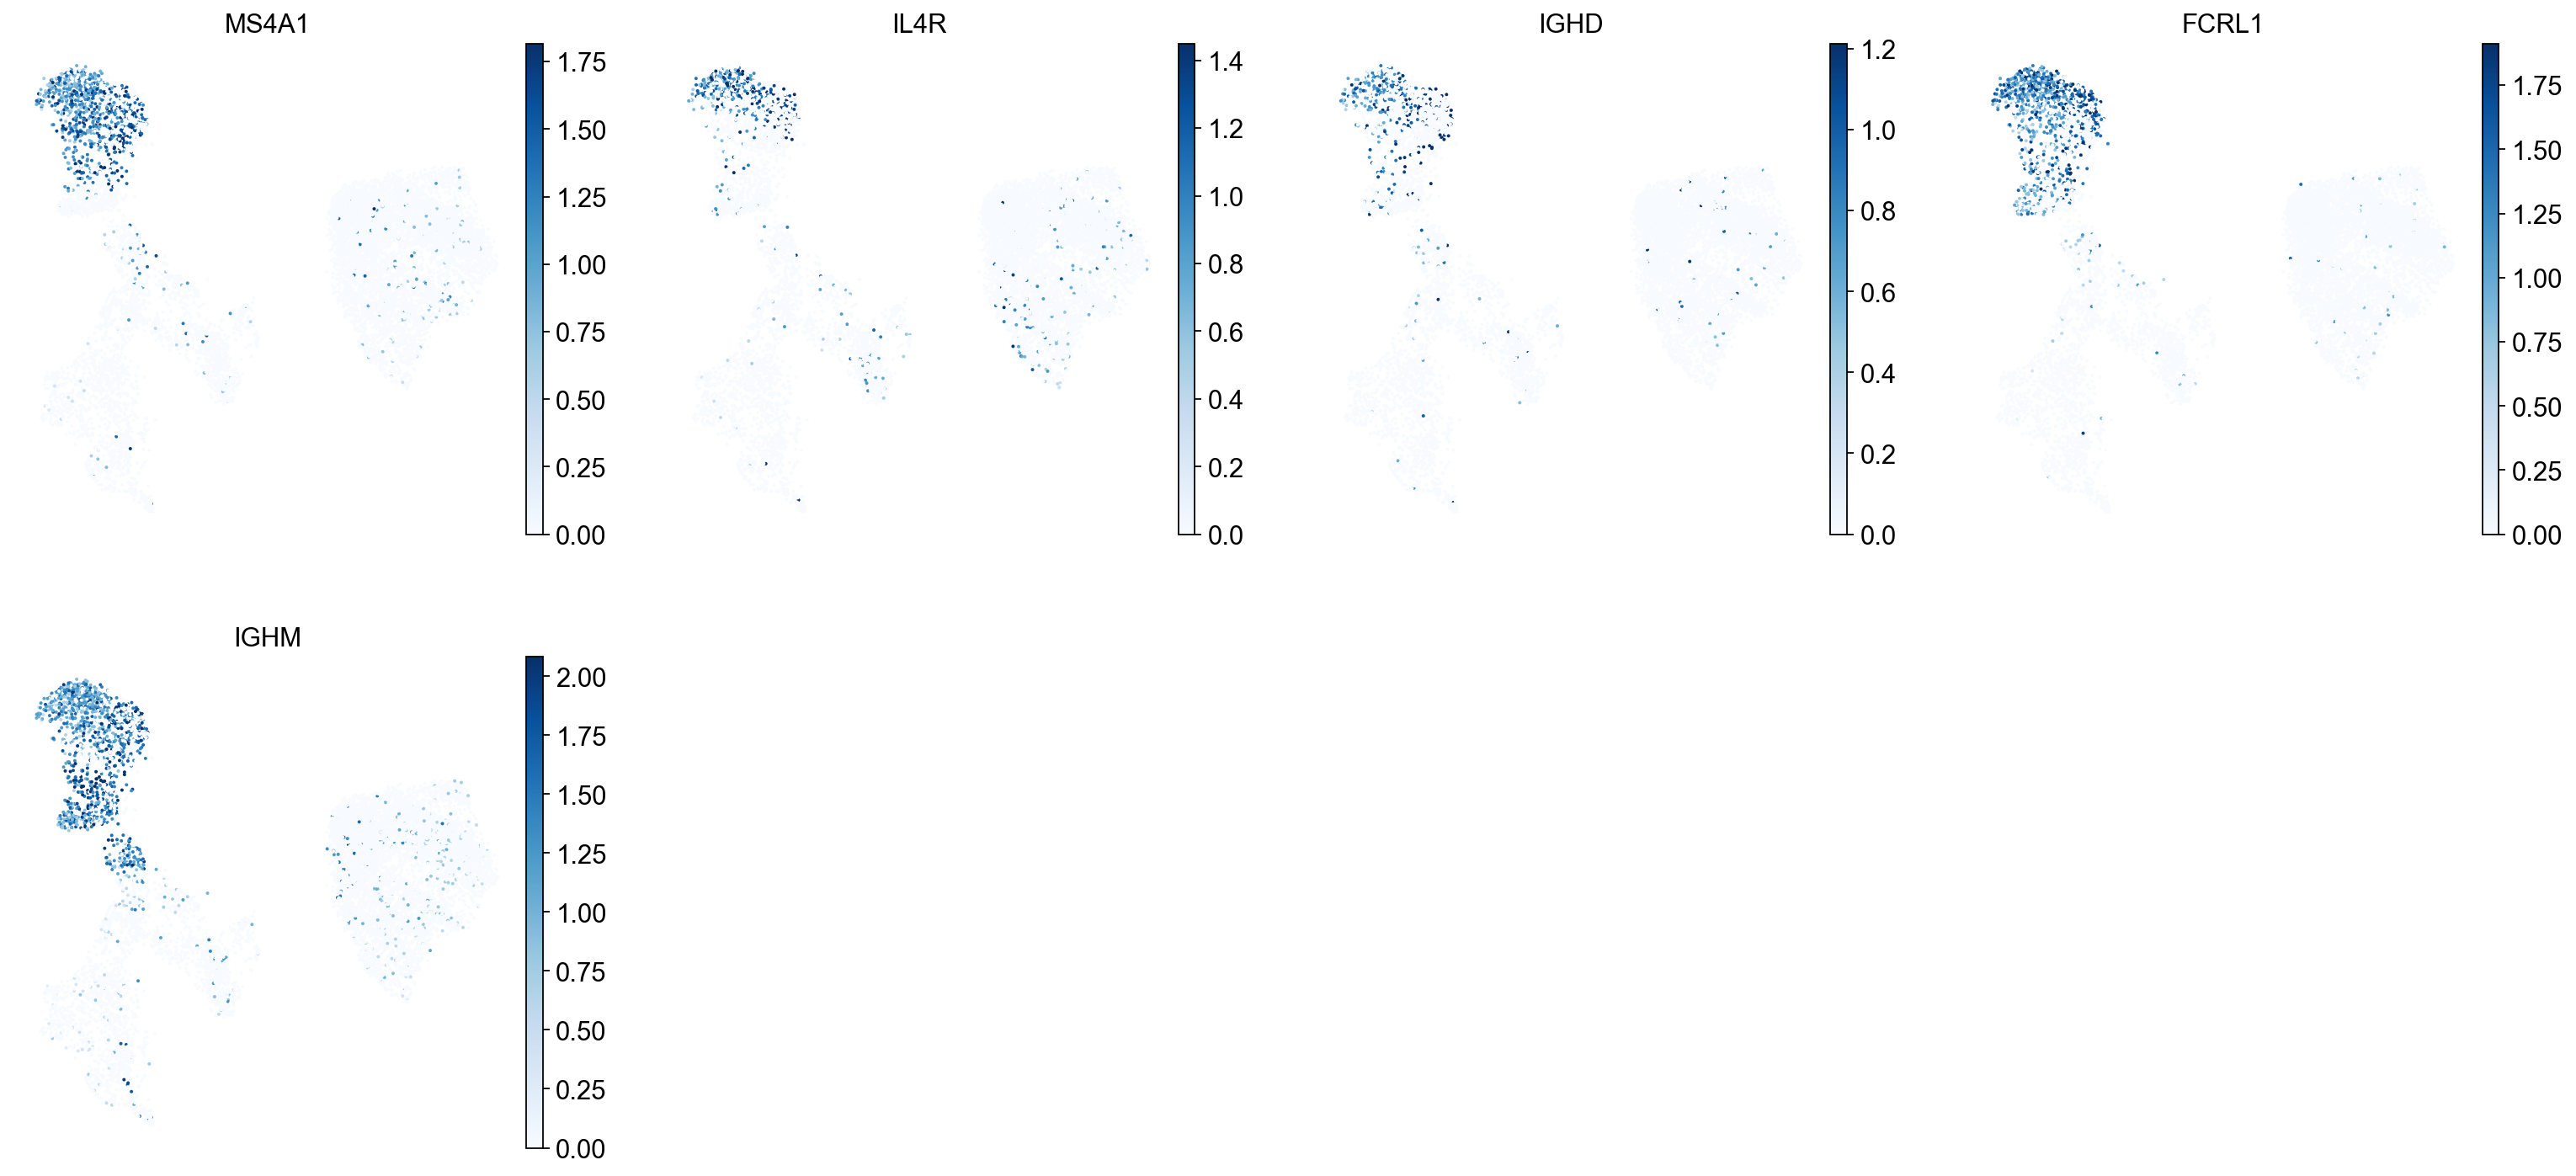





B1 B:


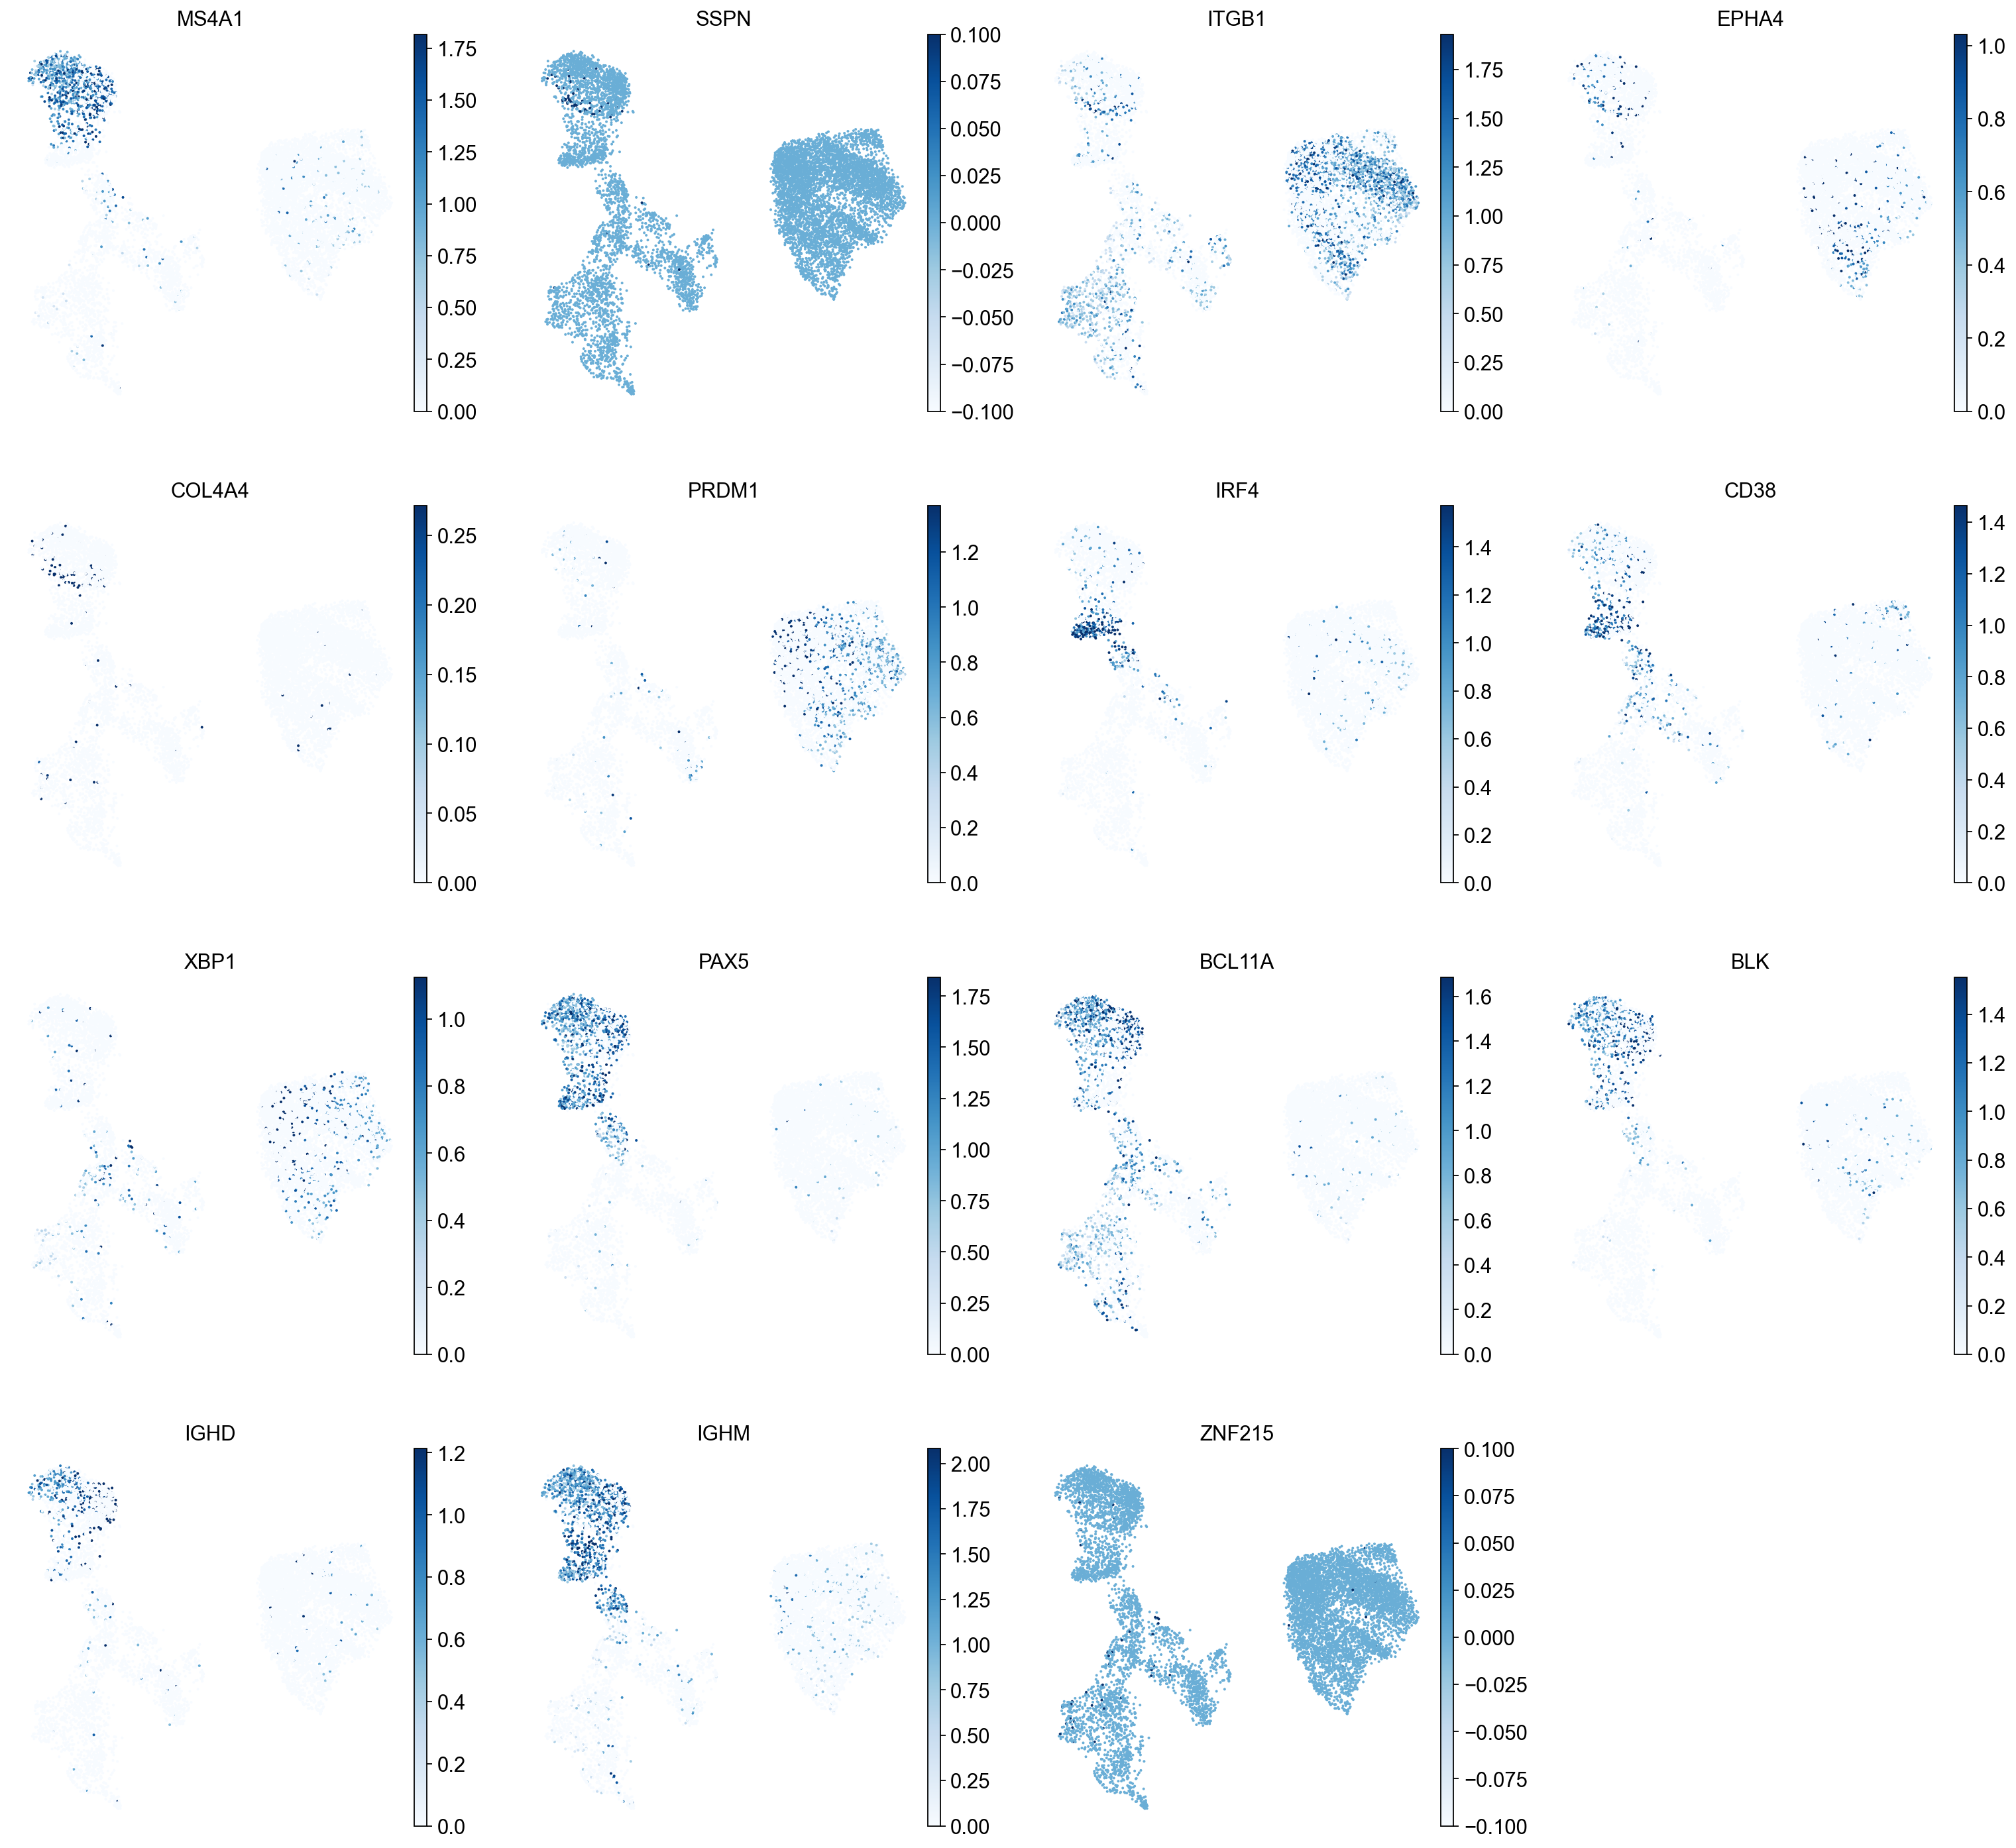





TRANSITIONAL B:


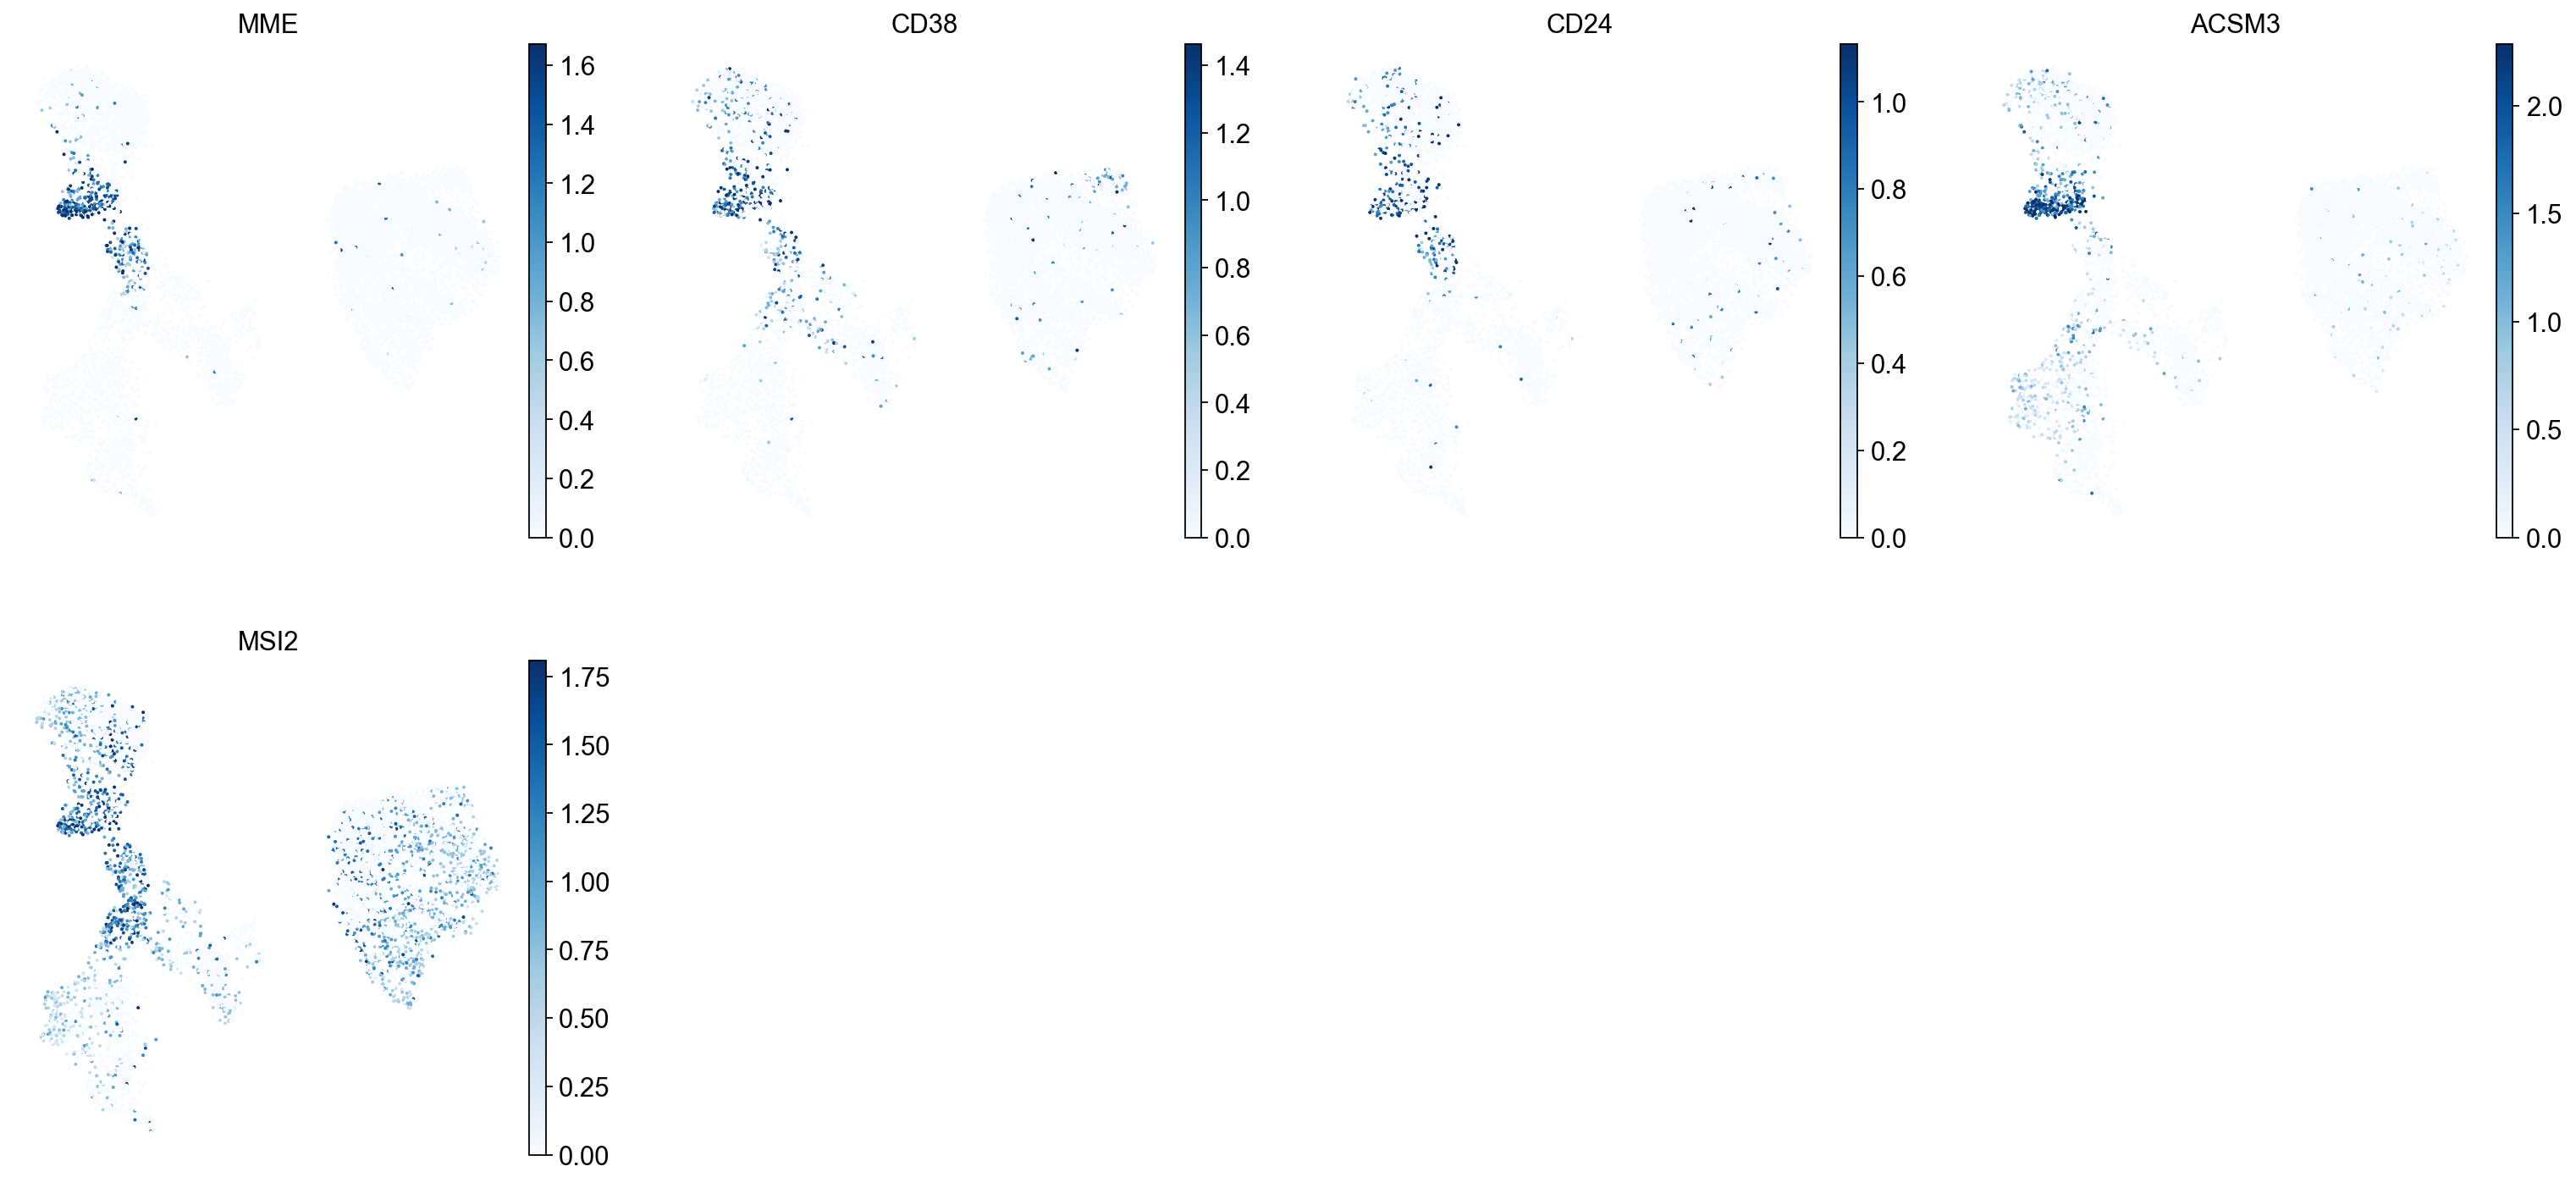





PLASMA CELLS:


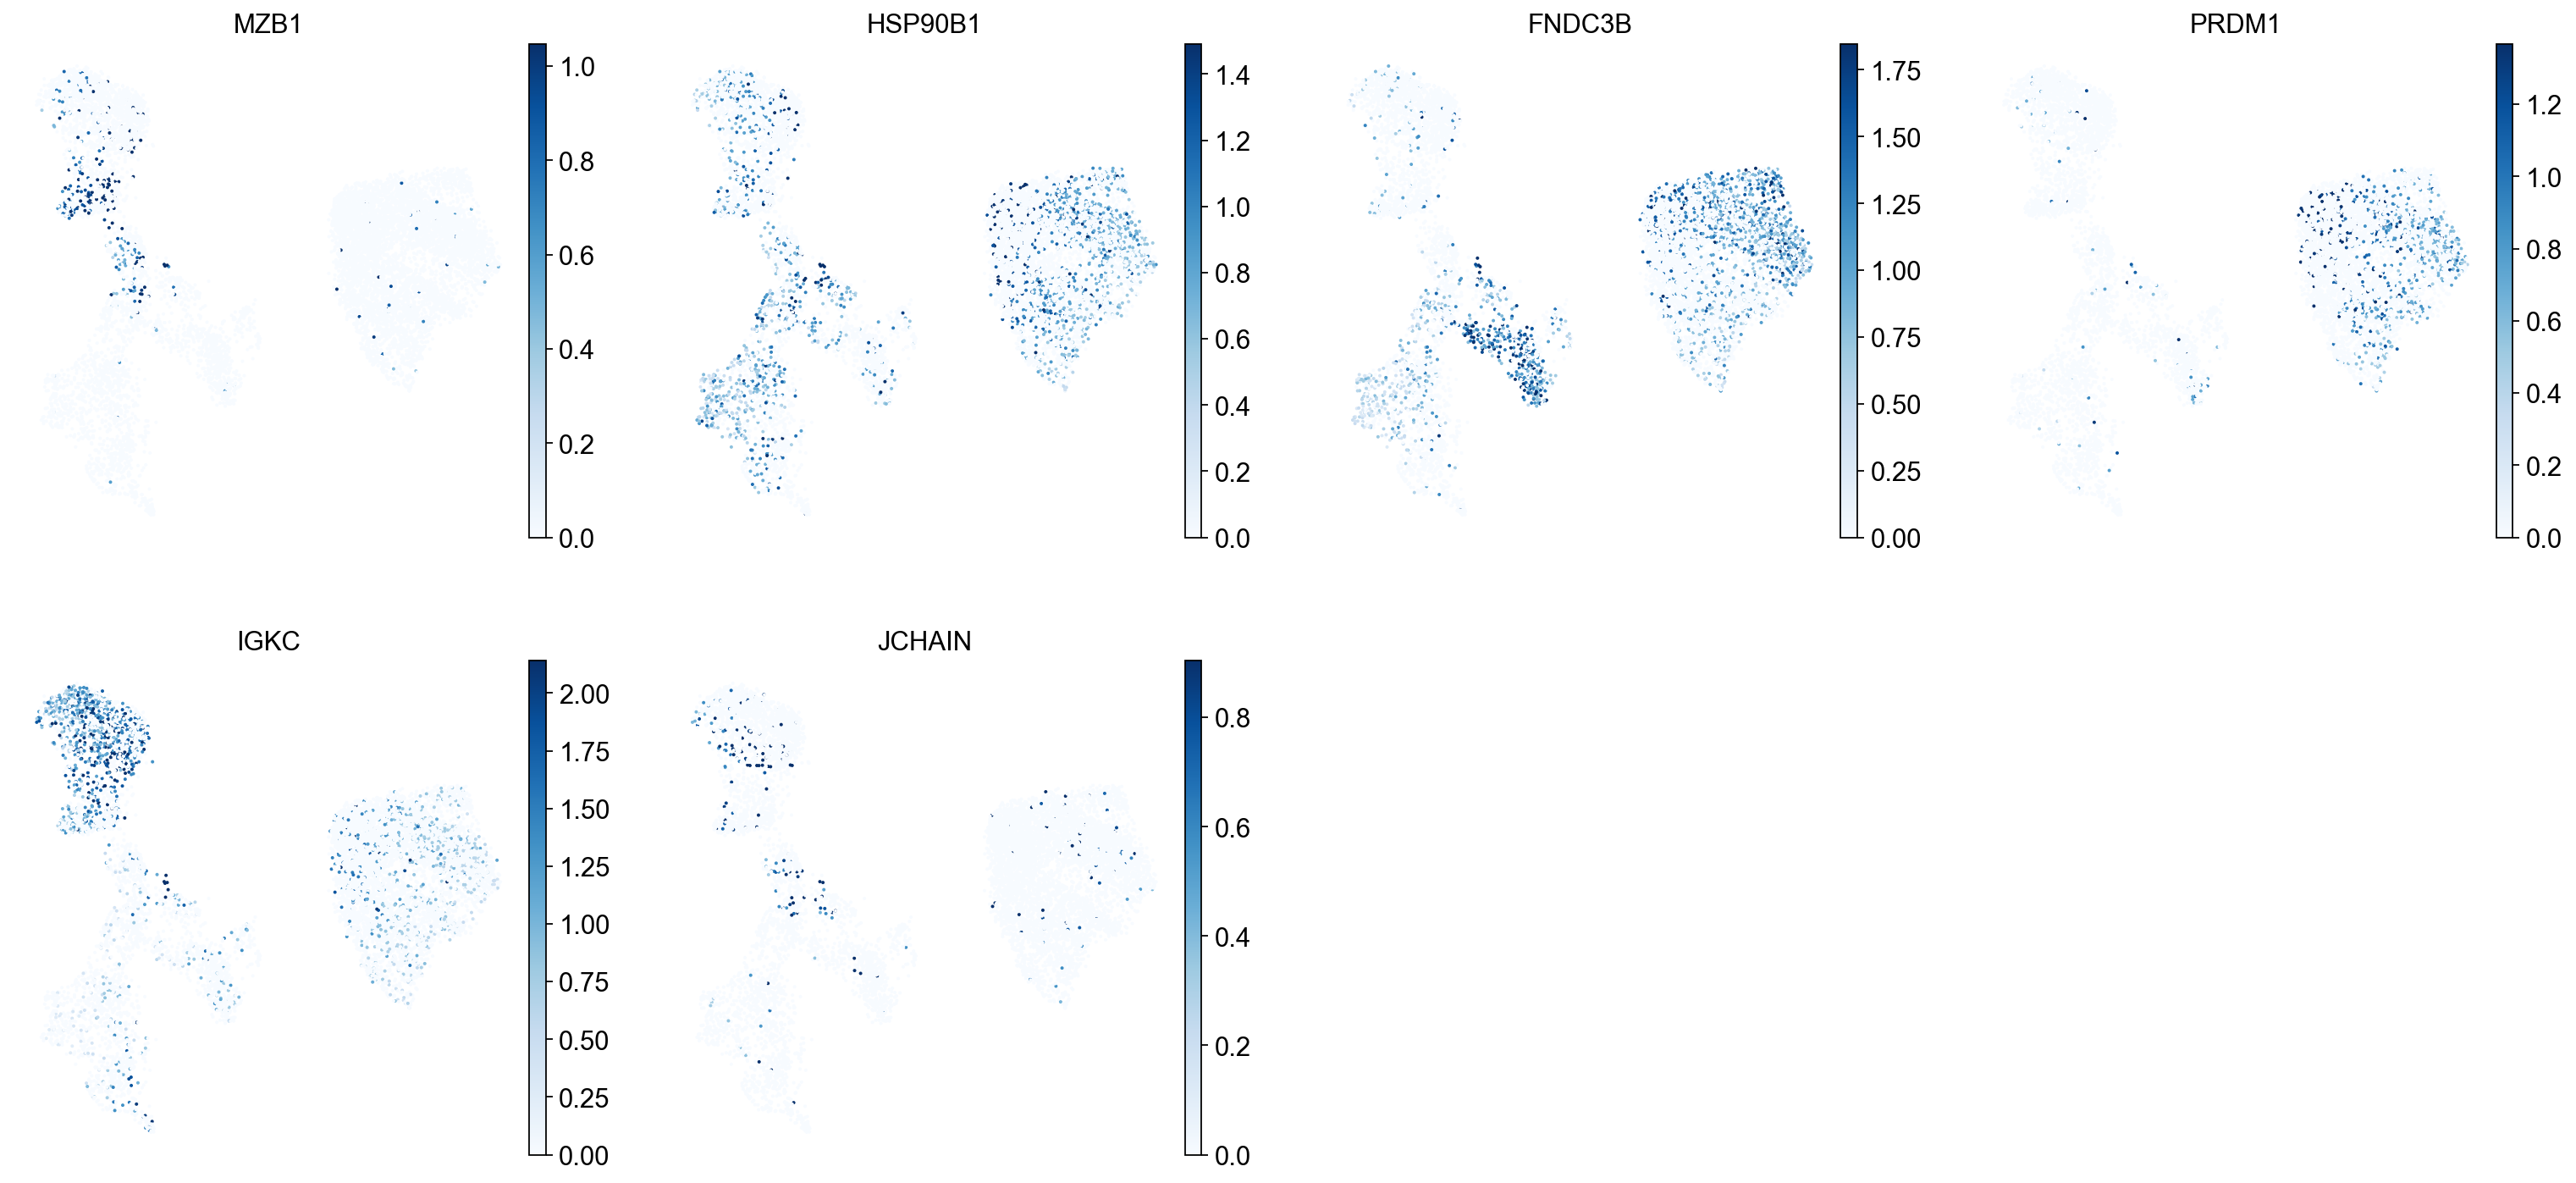





PLASMABLAST:


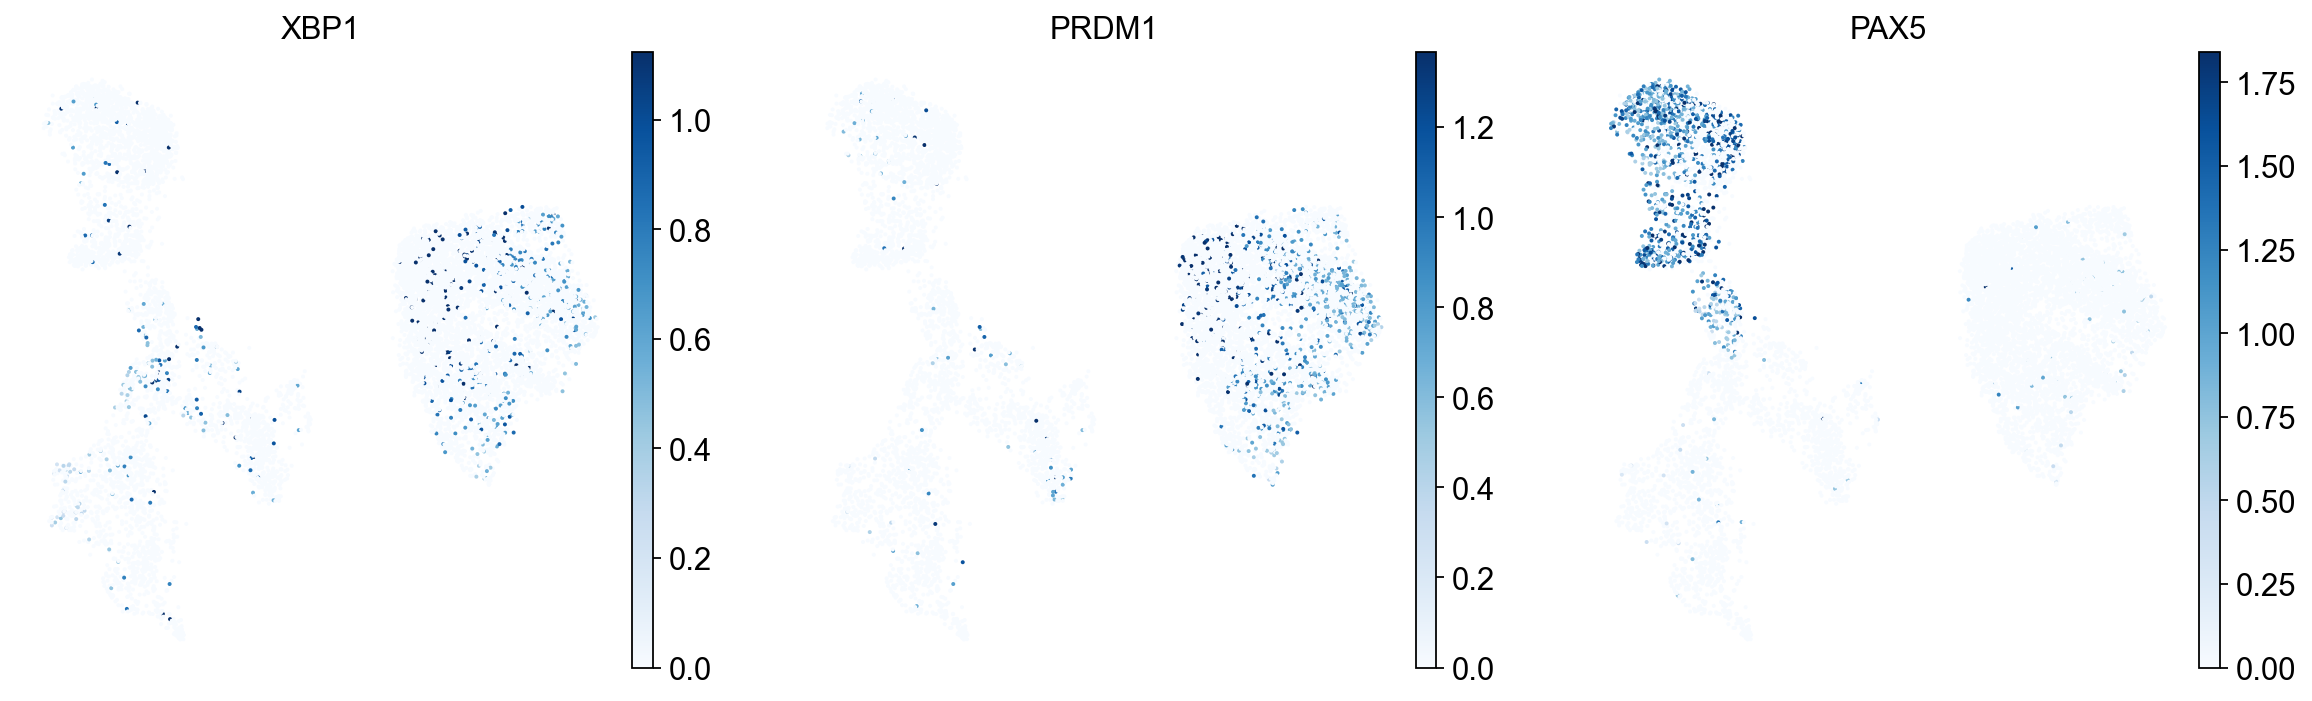

In [20]:
for ct in B_plasma_cts:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Blues",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

In [23]:
sc.tl.leiden(adata, resolution=1, key_added="leiden_1")

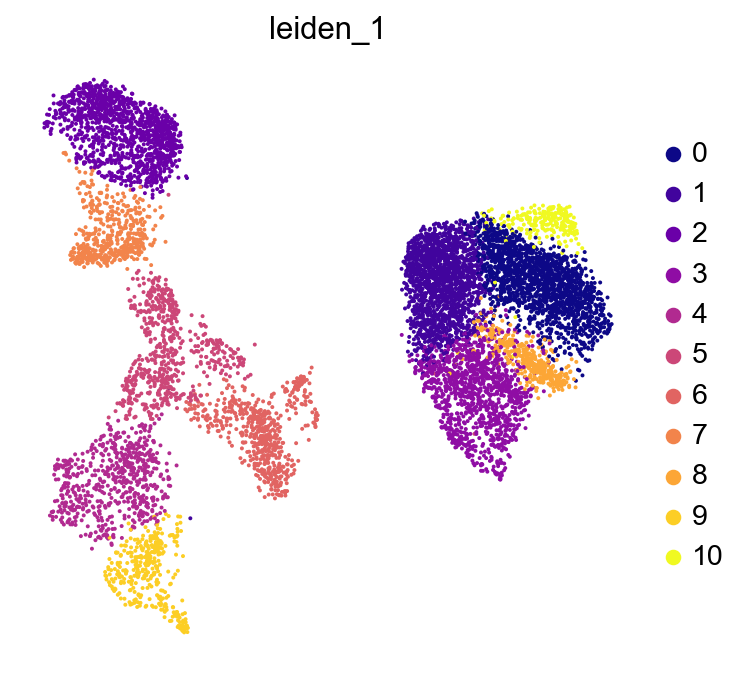

In [28]:
sc.pl.umap(adata, color="leiden_1",palette='plasma',frameon=False)

In [29]:
sc.tl.leiden(adata, resolution=2, key_added="leiden_2")

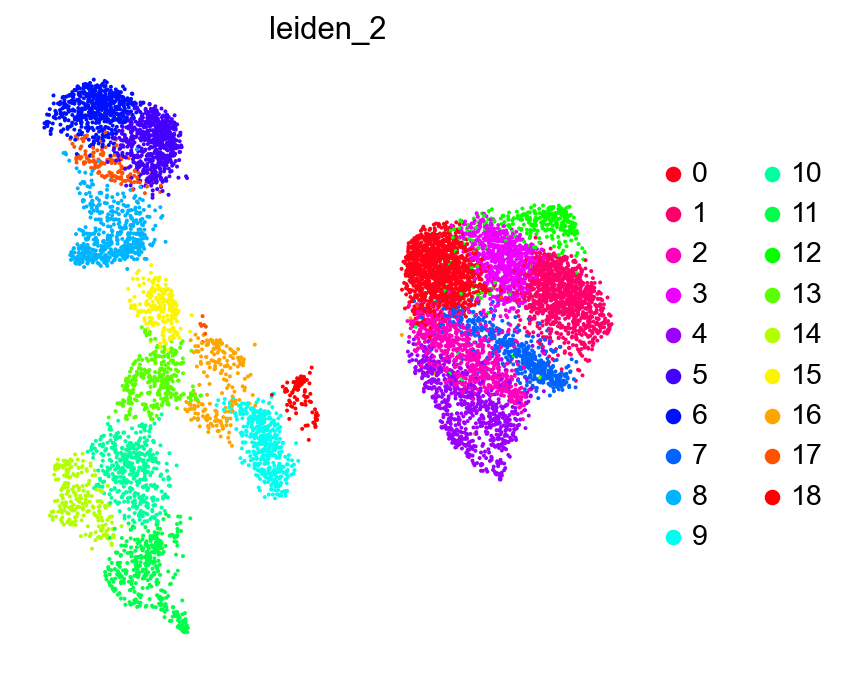

In [43]:
sc.pl.umap(adata, color="leiden_2",frameon=False,palette='hsv_r')

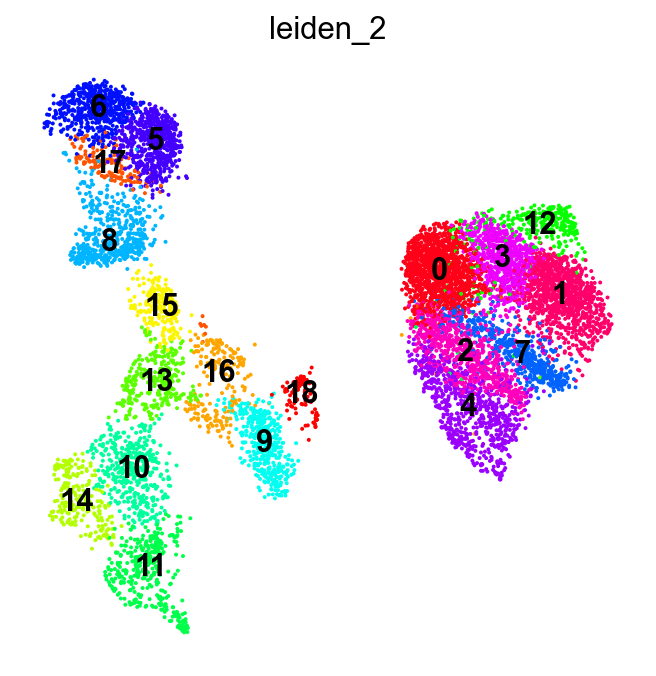

In [44]:
sc.pl.umap(adata, color="leiden_2", legend_loc="on data",frameon=False,palette='hsv_r')

In [45]:
B_plasma_markers = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes.items()
    if ct in B_plasma_cts
}

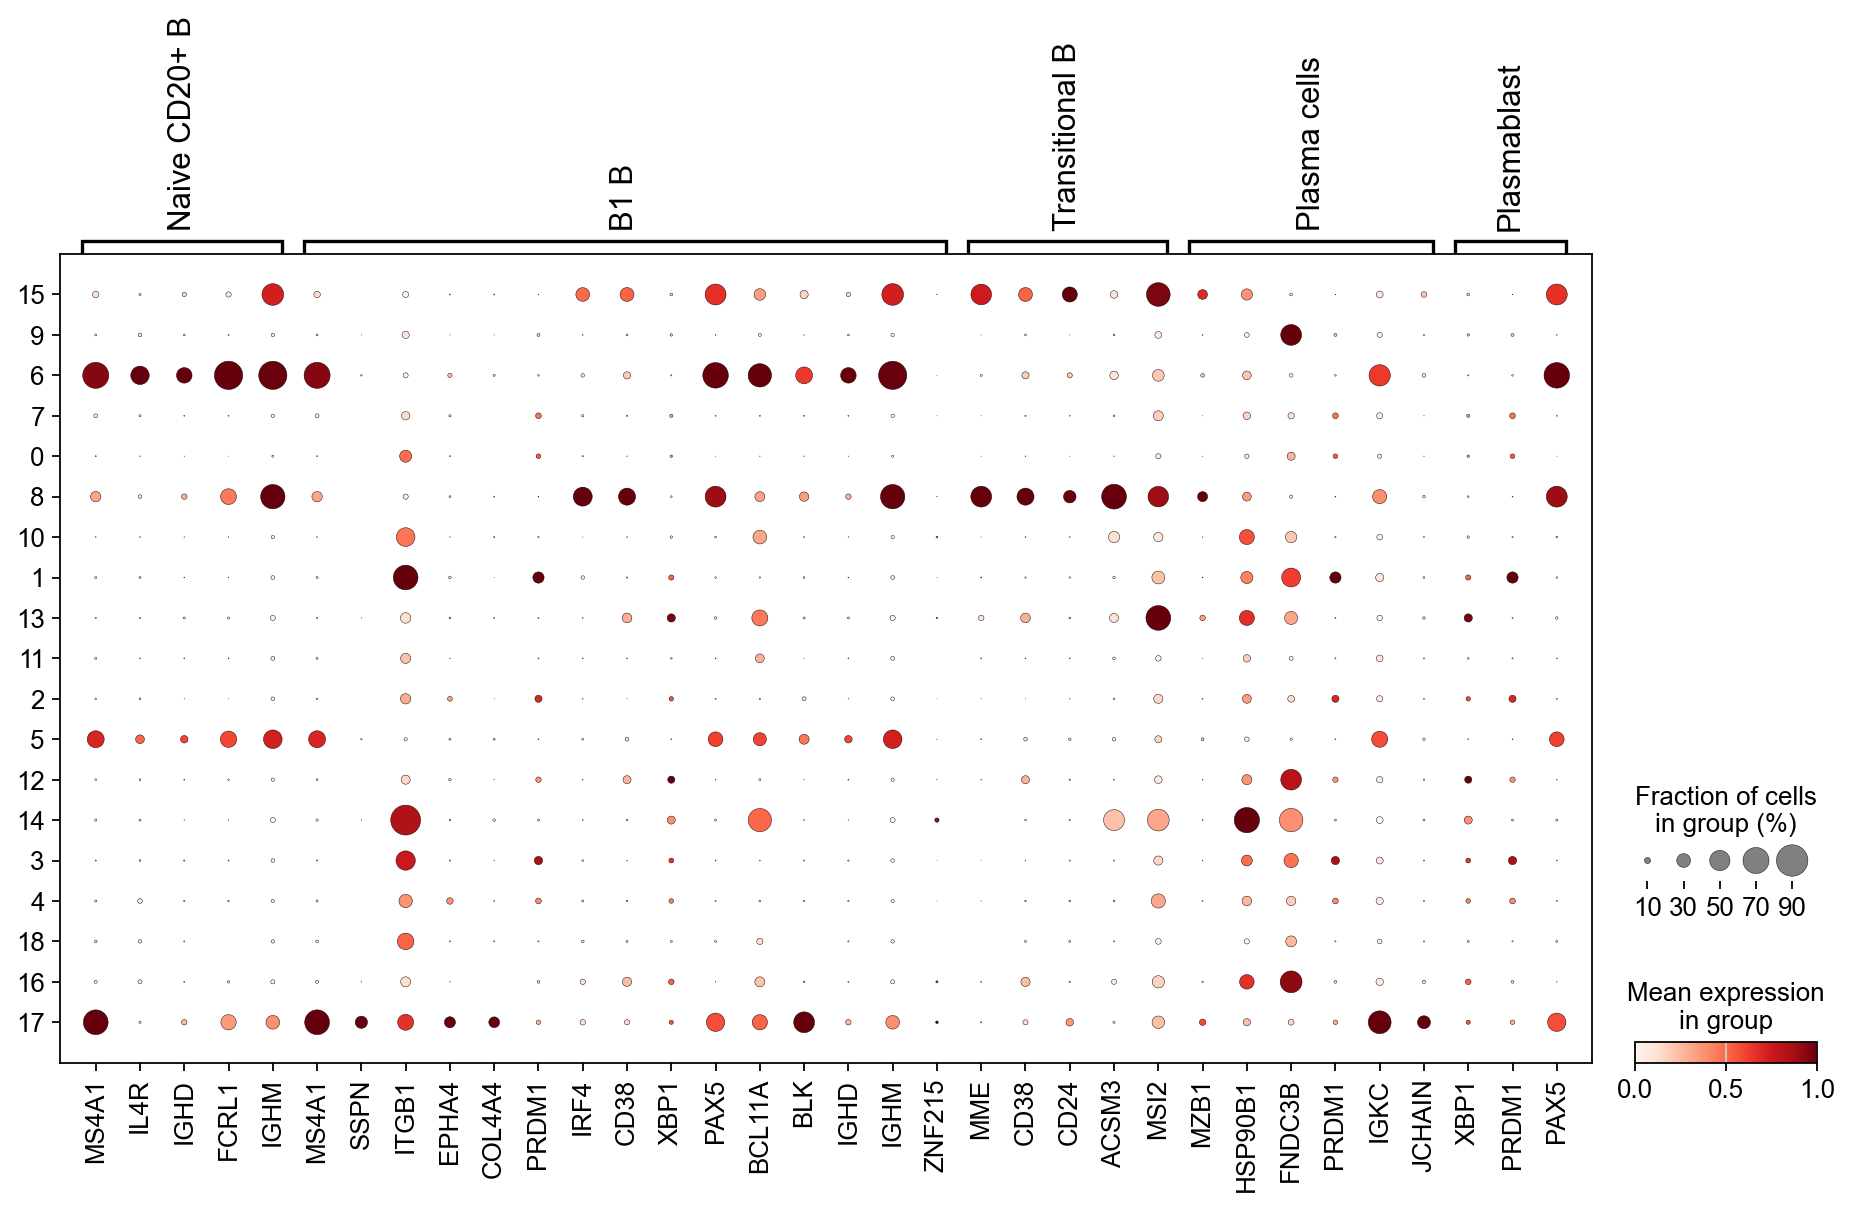

In [46]:
sc.pl.dotplot(
    adata,
    groupby="leiden_2",
    var_names=B_plasma_markers,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [47]:
cl_annotation = {
    "4": "Naive CD20+ B",
    "6": "Naive CD20+ B",
    "8": "Transitional B",
    "18": "B1 B",  # note that IGHD and IGHM are negative markers, in this case more lowly expressed than in the other B cell clusters
}

In [48]:
adata.obs["manual_celltype_annotation"] = adata.obs.leiden_2.map(cl_annotation)

... storing 'manual_celltype_annotation' as categorical


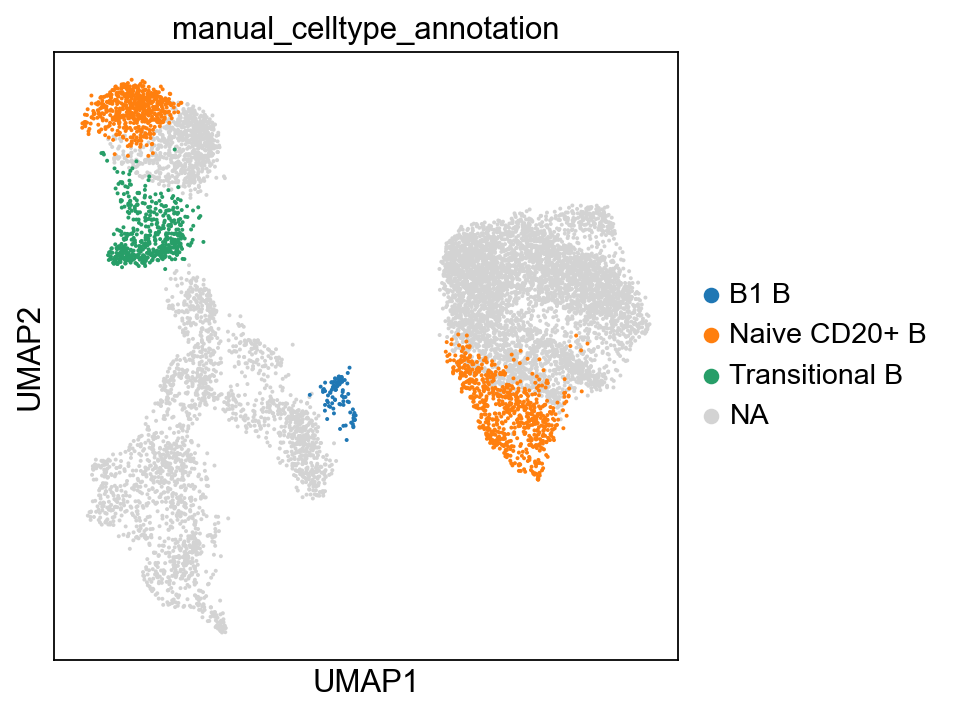

In [49]:
sc.pl.umap(adata, color=["manual_celltype_annotation"])

In [50]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden_2", method="wilcoxon", key_added="dea_leiden_2"
)

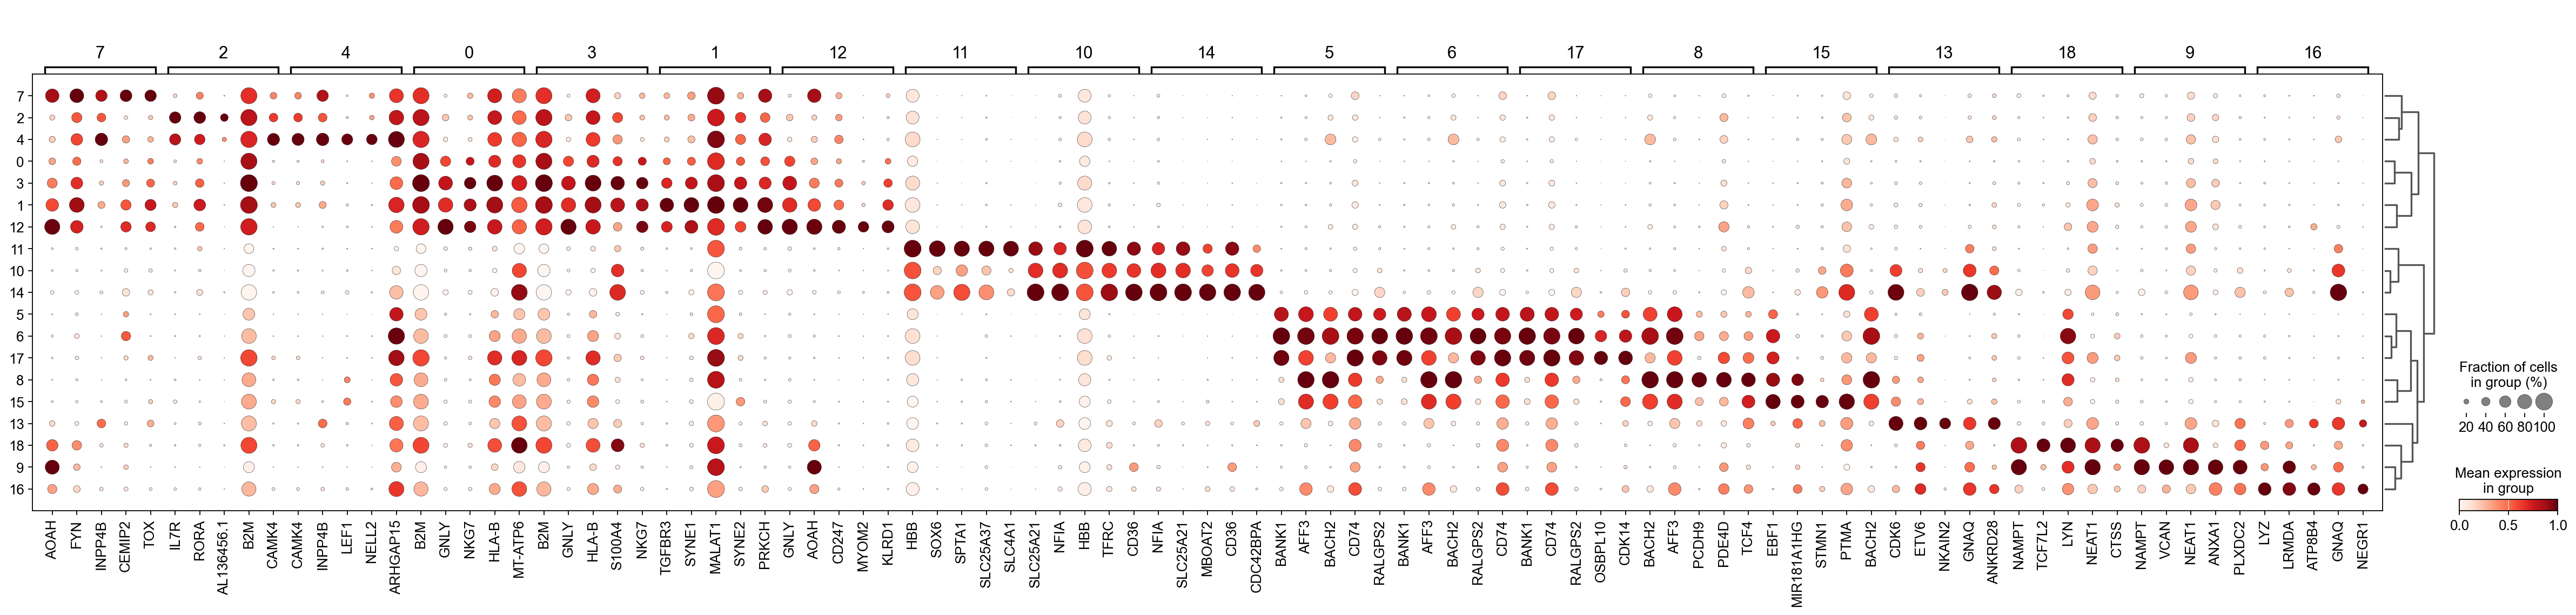

In [51]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_2", standard_scale="var", n_genes=5, key="dea_leiden_2"
)

In [52]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_2",
    key_added="dea_leiden_2_filtered",
)

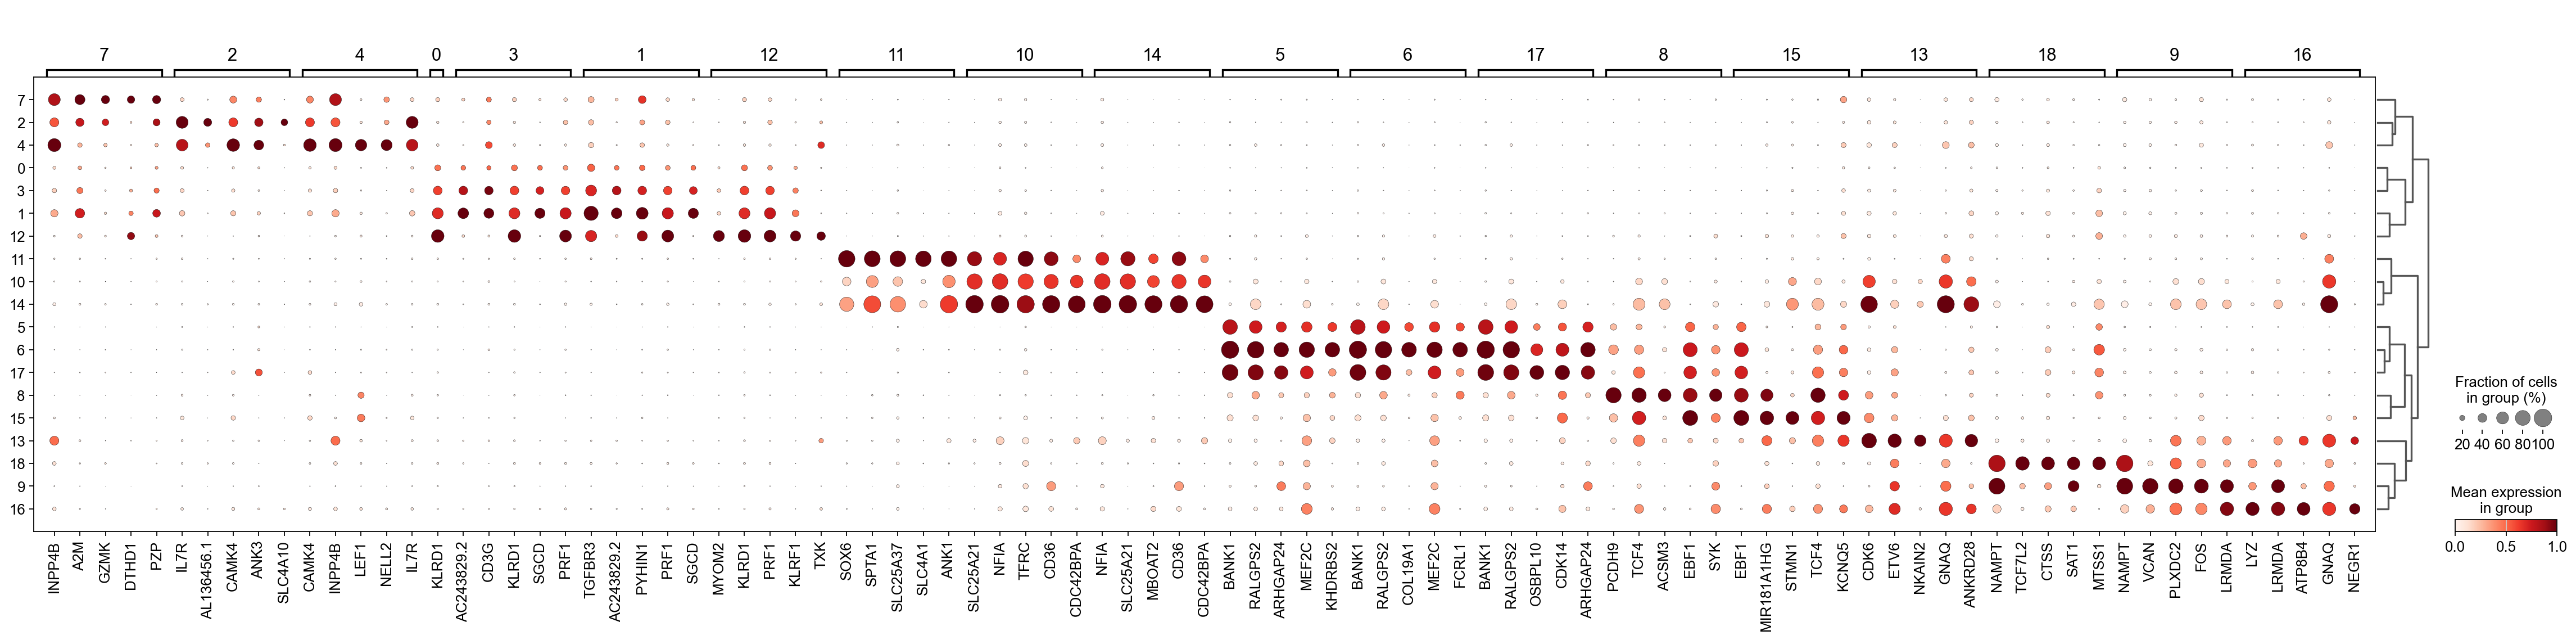

In [53]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_2",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_2_filtered",
)

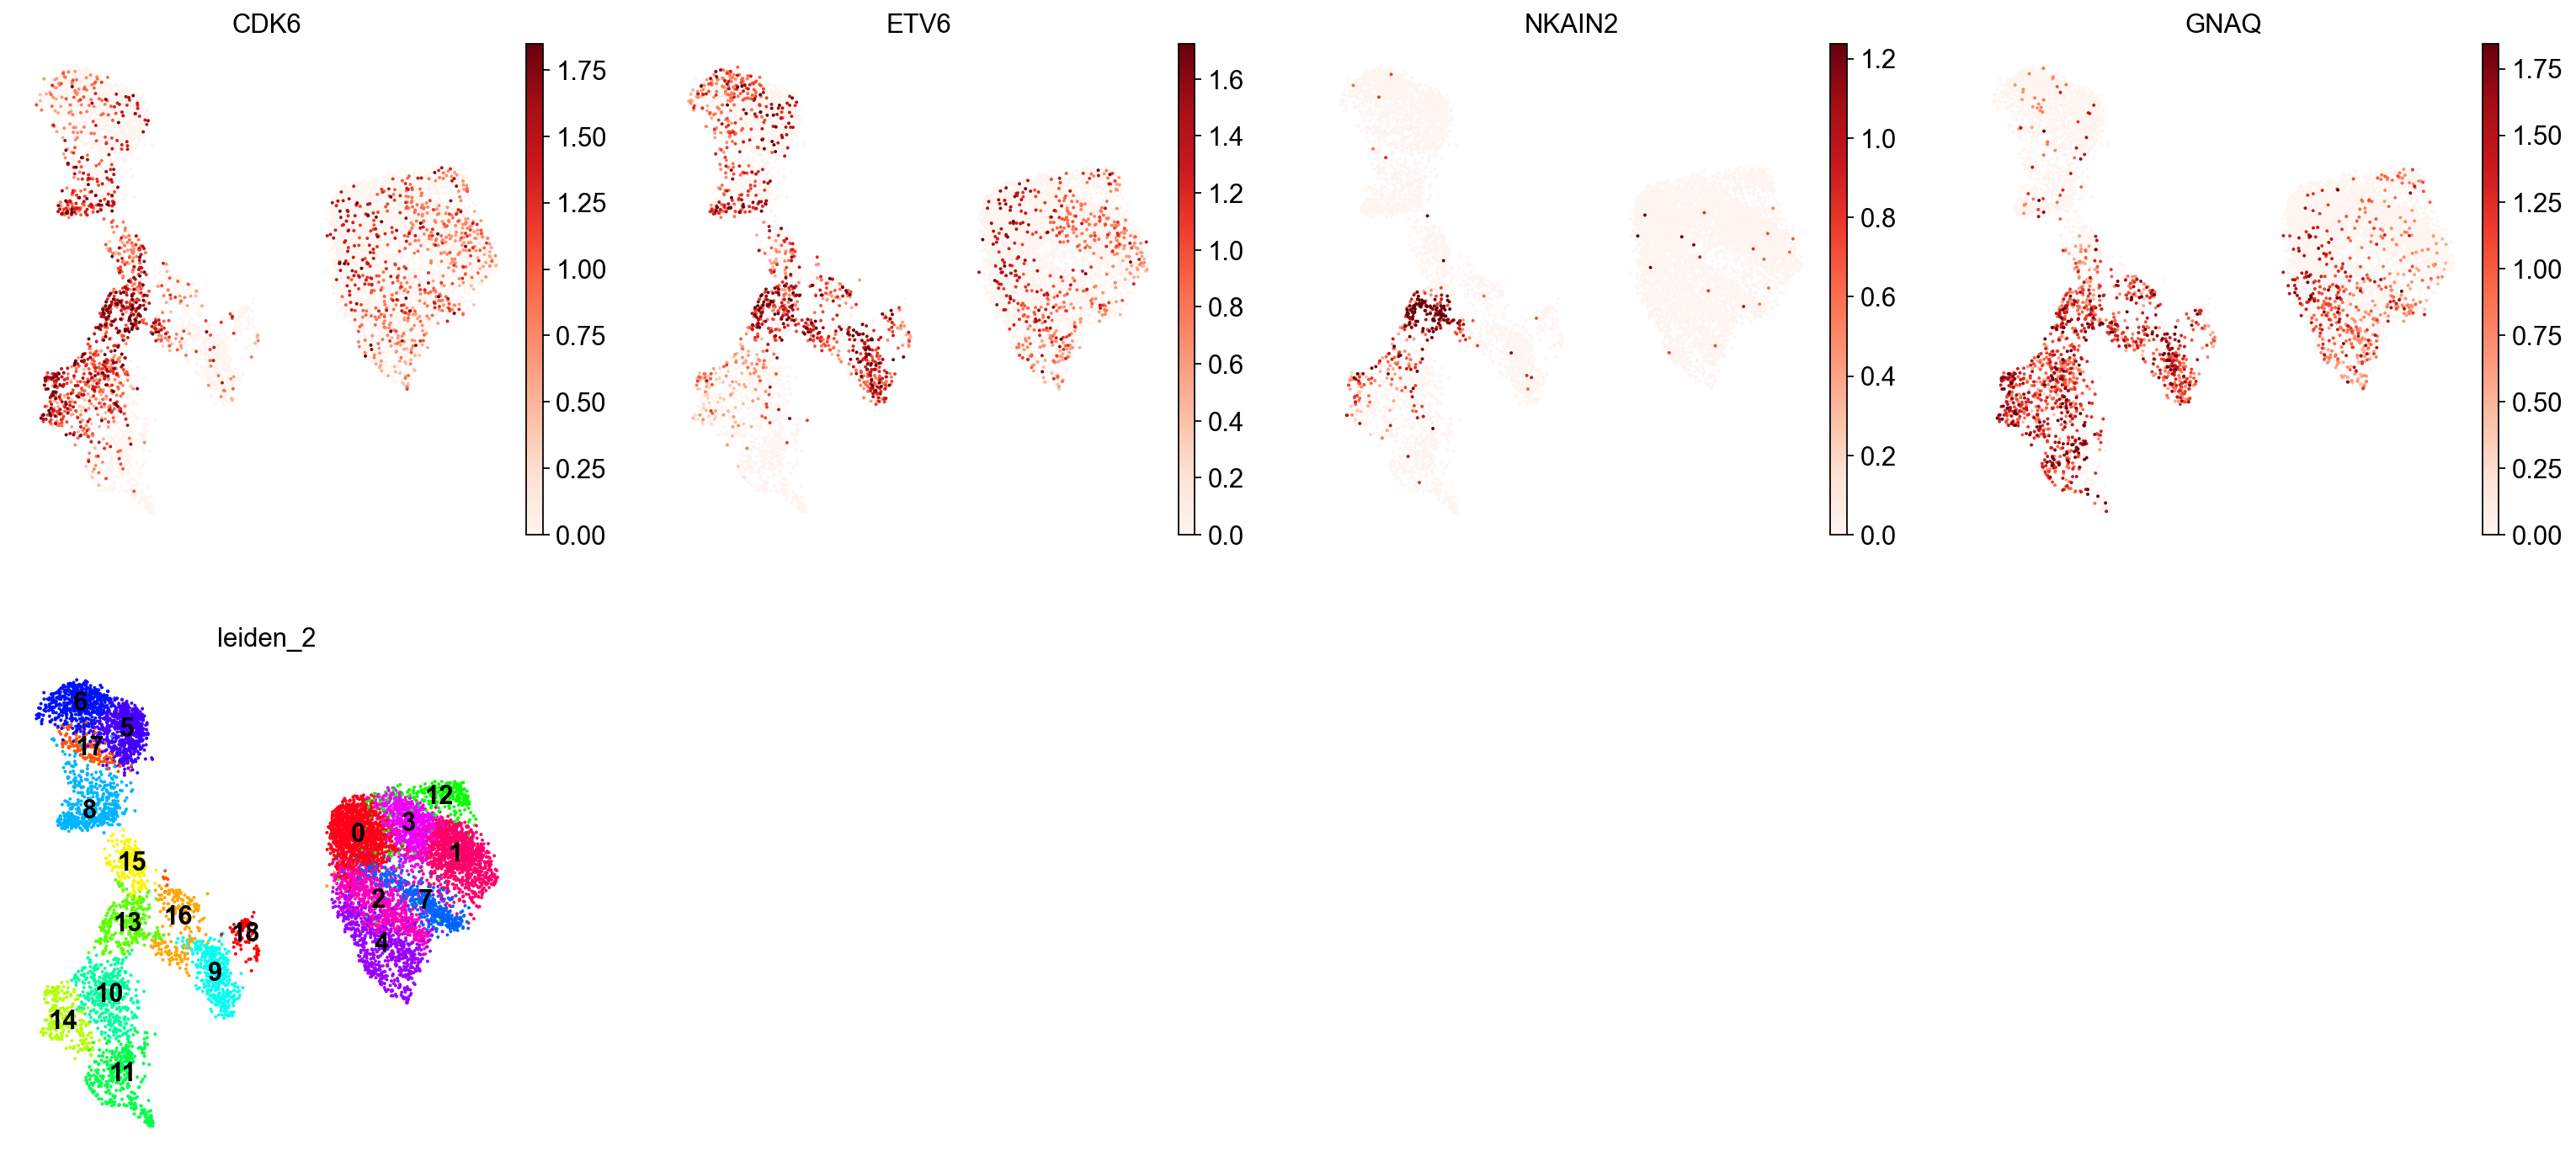

In [54]:
sc.pl.umap(
    adata,
    color=["CDK6", "ETV6", "NKAIN2", "GNAQ", "leiden_2"],
    vmax="p99",
    legend_loc="on data",
    frameon=False,
    cmap="Reds",
)